# Summary

This notebook shows how to read in a void catalog with VAST, compute and display void statistics, and make visualization plots with voids

### Read in Void Catalogs

Instructions: First run `python SDSS_VoidFinder_dr7.py` to generate `vollim_dr7_cbp_102709_VoidFinder_Output.fits` and run `python vsquared.py -m 4 -c DR7_config.ini -v`* to generate `DR7_V2_REVOLVER_Output.fits`

\*The `-m 4` choses REVOLVER as out V2 pruning method. We can alternatively use `-m 0` for VIDE or `-m 1` for ZOBOV. The `-v` causes the algorithm to calculate rendering information for the voids that we can use to make slice plots (warning: this adds signifigantly to the runtime)

In [1]:
# Import the void catalog class
from vast.catalog.void_catalog import VoidFinderCatalog, V2Catalog

In [2]:
# Data paths
voidfinder_voids_path = 'vollim_dr7_cbp_102709_VoidFinder_Output.fits'
vsquared_voids_path = 'DR7_V2_REVOLVER_Output.fits'
galaxies_path = 'vollim_dr7_cbp_102709.fits'

In [3]:
# Load void catalogs and add galaxies
voidfinder_catalog = VoidFinderCatalog(voidfinder_voids_path)
voidfinder_catalog.add_galaxies(galaxies_path, redshift_name='z')
vsquared_catalog = V2Catalog(vsquared_voids_path)
vsquared_catalog.add_galaxies(galaxies_path, redshift_name='z')

# Note: if our void catalog is split across multiple files (such as having a NGC and SGC catalog) we can load the catalog with
# from vast.catalog.void_catalog import VoidFinderCatalogStacked, V2CatalogStacked
# voidfinder_catalog = VoidFinderCatalogStacked(['NGC','SGC'],[voidfinder_voids_ngc_path, voidfinder_voids_sgc_path])
# We can then index into the files like so
# voidfinder_catalog['NGC']

# Note: The catalogs by default apply a 30 Mpc/h edge buffer to the reported statistics for the void radii, 
# void volume fraction and galaxy void membership. This buffer helps reduce survey edge effects. If we wish to remove 
# the edge buffer, we can do this:
# voidfinder_catalog = VoidFinderCatalog(voidfinder_voids_path, edge_buffer=0)


In [4]:
# For the full analysis of the V2 catalog, we need to give it an angular survey mask. 
# We can give it the VoidFinder catalog's mask, which is calculated and saved by that algorithm
vsquared_catalog.mask = voidfinder_catalog.mask
vsquared_catalog.mask_info = voidfinder_catalog.mask_info
vsquared_catalog.info['MSKRES'] = voidfinder_catalog.info['MSKRES']

In [5]:
# To see the fits header of a catalog, we can do
voidfinder_catalog.info

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
INFILE  = 'vollim_dr7_cbp_102709.dat' / Input Galaxy Table                      
METRIC  = 'comoving'           / Distance Metric                                
DLIML   =                  0.0 / Lower Distance Limit (Mpc/h)                   
DLIMU   =               301.27 / Upper Distance Limit (Mpc/h)                   
ZLIML   =                    0 / Lower Redshift Limit                           
ZLIMU   =               0.1026 / Upper Redshift Limit                           
OMEGAM  =                 0.26 / Matter Density                                 
HP      =                  1.0 / Reduced Hubble Parameter h (((km/s)/Mpc)/100)  
NNS     =                   

In [6]:
# The following internal tables are availible to us for each algorithm
# ==VoidFinder==
# maximal spheres: voidfinder_catalog.maximals
# hole spheres: voidfinder_catalog.holes
# angular mask: voidfinder_catalog.mask
# wall galaxies: voidfinder_catalog.wall (if VAST user elects to save galaxy input)
# field galaxies: voidfinder_catalog.field (if VAST user elects to save galaxy input)
# ==V2==
# voids: vsquared_catalog.voids
# zones: vsquared_catalog.zonevoid
# galaxy cells: vsquared_catalog.galzone
# cell triangles: vsquared_catalog.triangle (if user elects to save visualization data)
# galaxy visualization info: vsquared_catalog.galviz (if user elects to save visualization data)

# As an example, here are the first five entries for the VoidFinder maximals table
voidfinder_catalog.maximals[:5]

x,y,z,radius,void,edge,r,ra,dec,r_eff,r_eff_uncert
Mpc / h,Mpc / h,Mpc / h,Mpc / h,,,Mpc / h,deg,deg,Mpc / h,Mpc / h
float64,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64
-204.46043604485274,166.95562201034653,103.91598681840927,22.14716893725866,0,1,283.684299785795,140.76606261549136,21.488135813839925,29.099489099781547,0.09925551438669936
-209.94935906654266,-128.89517665169504,145.8188461746319,22.06946628156757,1,1,286.27929690465686,211.54720384554165,30.621121500605817,27.651316525546925,0.10020722788990634
-77.6791851617463,34.094247115529456,160.01931824271935,21.34506524313025,2,1,181.1150344522297,156.30280227025654,62.07031890886661,27.683590939839124,0.10018286755430439
-221.45065750592912,55.70979988610306,134.49848954102728,21.284898307848238,3,0,265.0166394813273,165.87925680772136,30.498087579262254,28.965123082688084,0.10800009007468082
-233.68967836689313,112.45170394422706,106.65049920076686,21.269649958633607,4,1,280.4114485447319,154.30309426106007,22.354481467112116,28.36299632154682,0.0973454952286299


In [7]:
# The hdu header for each table can be accesed by appending "_info" to the table name
voidfinder_catalog.maximals_info

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   88 / length of dimension 1                          
NAXIS2  =                  897 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                   11 / number of table fields                         
EXTNAME = 'MAXIMALS'           / extension name                                 
VOID    =                  897 / Void Count                                     
TTYPE1  = 'x       '                                                            
TFORM1  = 'D       '                                                            
TUNIT1  = 'Mpc h-1 '        

In [8]:
# We can access the first five entries of our loaded galaxy catalog like so
voidfinder_catalog.galaxies[:5]

redshift,ra,dec,weight,gal,Rgal,x,y,z
float32,float32,float32,float32,int64,float32,float32,float32,float32
0.077352,171.59215,-1.054439,1.0,0,228.32727,-225.83504,33.380028,-4.201768
0.07771,174.53622,-1.051174,1.0,1,229.36711,-228.28658,21.835844,-4.207835
0.084655,239.38278,-0.467646,1.0,2,249.50829,-127.07038,-214.71692,-2.0364547
0.051608,239.6791,-0.448756,1.0,3,153.13832,-77.30837,-132.18669,-1.1994084
0.051549,239.69847,-0.450346,1.0,4,152.9651,-77.17628,-132.06325,-1.2022965


### Catalog General Properties

In [ ]:
# Calculate VoidFinder-specific properties
# This may take a while, particularly the effective radius calculation
vflag_path = 'vollim_dr7_cbp_102709_VoidFinder_vflags.fits' #output destination for vflag calculation
voidfinder_catalog.calculate_vflag(vflag_path) #void galaxy membership
voidfinder_catalog.calculate_r_eff() #effective void radii


In [ ]:
# Likewise for V2
vflag_path = 'vollim_dr7_cbp_102709_V2_vflags.fits' #output destination for vflag calculation
vsquared_catalog.calculate_vflag(vflag_path) #void galaxy membership
# Note: unlike VoidFinder, V2 does not require pre-computation with calculate_vflag for running the galaxy_membership method (see below sections)
# calculate_vflag is included in the V2 class to allow comparisons with VoidFinder

In [9]:
# After we create a file identifying which galaxies are in VoidFinder or V2 voids, we can load it in
# instead of running calculate_vflag
vflag_path = 'vollim_dr7_cbp_102709_VoidFinder_vflags.fits' #output destination for vflag calculation
voidfinder_catalog.add_galaxies(galaxies_path, vflag_path = vflag_path, redshift_name='z')
vflag_path = 'vollim_dr7_cbp_102709_V2_vflags.fits' #output destination for vflag calculation
vsquared_catalog.add_galaxies(galaxies_path, vflag_path = vflag_path, redshift_name='z')

In [10]:
# Print text highlighted in red
redtext = lambda x: f"\x1b[31m{x}\x1b[0m"

In [11]:
# Calculate catalog properties
print('\n'+redtext("SDSS VoidFinder"),'\n')
voidfinder_catalog.void_stats()
print('\n'+redtext("SDSS V2/REVOLVER"),'\n')
# Note: V2 will not output edge void statistics unless we use a branch of VAST that calculates 
# them during the voidfinding (e.g., https://github.com/DESI-UR/VAST/tree/fits_edge)
# Note: "V. Fid" in the below output refers to the internal fiducal volume defined by the catalog edge buffer
vsquared_catalog.void_stats()


SDSS VoidFinder 

897 voids
306 edge voids
15 near-edge voids
576 interior voids
3 edge voids (V. Fid)
0 near-edge voids (V. Fid)
464 interior voids (V. Fid)
Mean Reff (V. Fid): 16.83 +/- 0.107 Mpc/h
Median Reff (V. Fid): 16.22 +/- 0.134 Mpc/h
Maximum Reff (V. Fid): 28.97 Mpc/h

SDSS V2/REVOLVER 

310 voids
Mean Reff (V. Fid): 22.07 +/- 0.338 Mpc/h
Median Reff (V. Fid): 20.89 +/- 0.423 Mpc/h
Maximum Reff (V. Fid): 41.09 Mpc/h


### Void Volume Fraction

In [40]:
# Here we calculate the void volume fraction by creating a dense grid of points over the survey volume and 
# counting up the number of points inside and outside of voids.
# This may take a while to calculate
num_points_total, fraction_in_void, fraction_not_in_void = voidfinder_catalog.get_single_overlap()
voidfinder_volume_fraction = fraction_in_void
print(f'{voidfinder_volume_fraction * 100:.2f} percent of survey volume in VoidFinder voids')
num_points_total, fraction_in_void, fraction_not_in_void = vsquared_catalog.get_single_overlap()
vsquared_volume_fraction = fraction_in_void
print(f'{vsquared_volume_fraction * 100:.2f} percent of survey volume in V2/REVOLVER voids')

# Note: we can use vast.catalog.void_catalog.get_overlap to calculate the combined volume fraction statistics 
# of two overlapping void catalogs

64.97 percent of survey volume in VoidFinder voids
99.25 percent of survey volume in V2/REVOLVER voids


### Environmental Classification of Galaxies

In [12]:
# The galaxy catalog we loaded in doesn't report the magnitudes, so let's 
# set the magnitudes to a value that will pass the cut (needed for subsequent calculations)
voidfinder_catalog.galaxies['rabsmag'] = -30
vsquared_catalog.galaxies['rabsmag'] = -30
vsquared_catalog.info['MAGLIM'] = 9999 # The V2 DR7 config file doesn't include a magnitude limit, so let's add one

In [16]:
len(vsquared_catalog.galaxies)

120606

In [15]:
num_galaxies_in_void,  num_galaxies

(50850, 3930)

In [13]:
num_galaxies_in_void, num_galaxies = vsquared_catalog.galaxy_membership()
vsquared_galaxy_fraction = num_galaxies_in_void / num_galaxies
print(f'{vsquared_galaxy_fraction * 100:.2f} percent of galaxies are in V2/REVOLVER voids')


92.83 percent of galaxies are in V2/REVOLVER voids


In [13]:
vflag, num_galaxies = vsquared_catalog.galaxy_membership(return_selector=True)


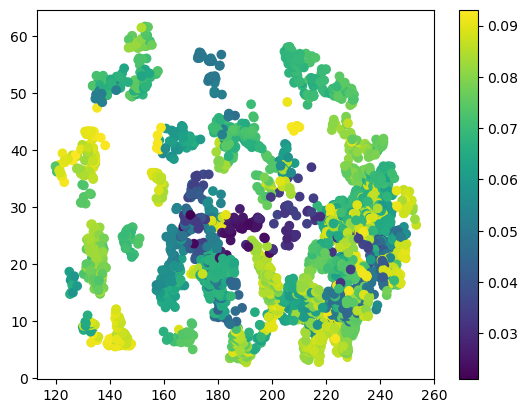

In [16]:
import matplotlib.pyplot as plt
#plt.scatter( vsquared_catalog.galaxies[vflag==1]['ra'], vsquared_catalog.galaxies[vflag==1]['dec'], color='r')
#plt.scatter( vsquared_catalog.galaxies[vflag==0]['ra'], vsquared_catalog.galaxies[vflag==0]['dec'], color='k')
scatter = plt.scatter( vsquared_catalog.galaxies[vflag==0]['ra'], vsquared_catalog.galaxies[vflag==0]['dec'], c=vsquared_catalog.galaxies[vflag==0]['redshift'])
plt.colorbar(scatter)

In [15]:
import numpy as np
vsquared_catalog.voids['void']=np.arange(len(vsquared_catalog.voids))

In [16]:
vsquared_catalog.triangle['void'] = vsquared_catalog.triangle['void_id']

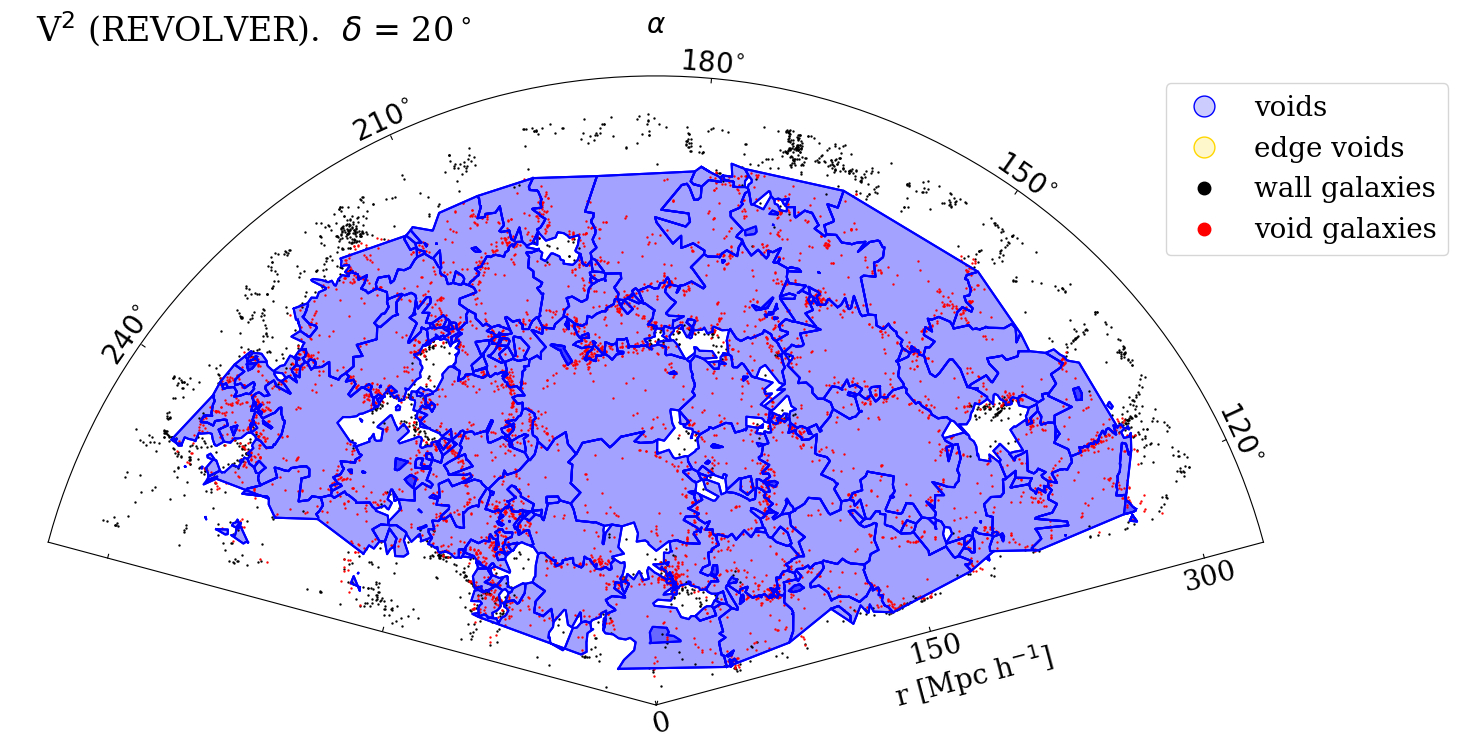

In [19]:
from vast.catalog.void_slice_plots import VoidMapVF, VoidMapV2
import matplotlib.pyplot as plt

vsquared_slice_plot = VoidMapV2(vsquared_catalog.triangle, vsquared_catalog.galzone, vsquared_catalog.zonevoid,
                   vsquared_catalog.voids, vsquared_catalog.galaxies)

plt.rcParams.update({'font.size': 20, 'font.family':'serif',"axes.titley":1.03 })

graph = vsquared_slice_plot.plot_survey(20,5,
    110, 260, 0, 0.114,"V$^2$ (REVOLVER). ", graph = None, zlimits = True, rot = 265, 
    colors = ['gold','blue'],include_gals=True,alpha=0.2, border_alpha = 1, mag_limit=-20, 
    horiz_legend_offset=0.9, galaxy_point_size=.5, plot_sdss=False)


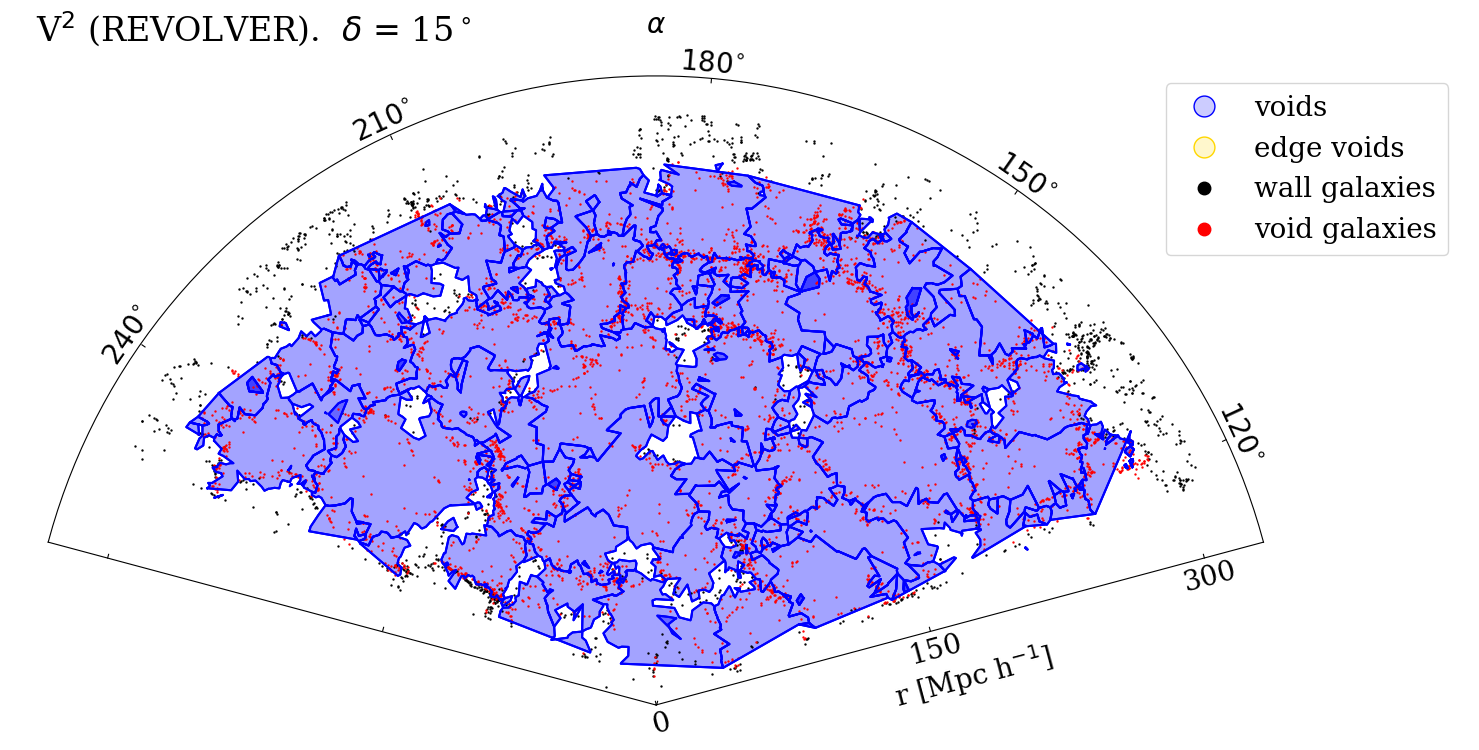

In [18]:
from vast.catalog.void_slice_plots import VoidMapVF, VoidMapV2
import matplotlib.pyplot as plt

vsquared_slice_plot = VoidMapV2(vsquared_catalog.triangle, vsquared_catalog.galzone, vsquared_catalog.zonevoid,
                   vsquared_catalog.voids, vsquared_catalog.galaxies)

plt.rcParams.update({'font.size': 20, 'font.family':'serif',"axes.titley":1.03 })

graph = vsquared_slice_plot.plot_survey(15,5,
    110, 260, 0, 0.114,"V$^2$ (REVOLVER). ", graph = None, zlimits = True, rot = 265, 
    colors = ['gold','blue'],include_gals=True,alpha=0.2, border_alpha = 1, mag_limit=-20, 
    horiz_legend_offset=0.9, galaxy_point_size=.5, plot_sdss=False)


In [15]:
len(vflag[vflag==1]), len(vflag[vflag==-1]), len(vflag[vflag==0]), len(vflag[vflag==2])

(50850, 30620, 3930, 15107)

In [16]:
50850/(3930+50850)

0.9282584884994524

In [14]:
import numpy as np
np.unique(vflag)

array([-1,  0,  1,  2,  9])

In [8]:
# Here we calculate how many galaxies in our catalog are located within voids
# Note that this may not be the same as the fraction of the voidfinding input galaxies within voids
# as the galaxy catalog may have had additonal cuts applied (magnitude, redshift etc.) before it was 
# inputted to the voidfinding algorithm.
num_galaxies_in_void, num_galaxies = voidfinder_catalog.galaxy_membership()
# Note: by default, the survey magnitude cut is applied. If we wish to disable it, we can instead do
# num_galaxies_in_void, num_galaxies = voidfinder_catalog.galaxy_membership(mag_lim=9999)
voidfinder_galaxy_fraction = num_galaxies_in_void / num_galaxies
print(f'{voidfinder_galaxy_fraction * 100:.2f} percent of galaxies are in VoidFinder voids')
# Note: if we want a boolean index to select galaxies in voids, we can run 
# boolean_index, num_galaxies = voidfinder_catalog.galaxy_membership()
num_galaxies_in_void, num_galaxies = vsquared_catalog.galaxy_membership()
vsquared_galaxy_fraction = num_galaxies_in_void / num_galaxies
print(f'{vsquared_galaxy_fraction * 100:.2f} percent of galaxies are in V2/REVOLVER voids')

# Note: we can use vast.catalog.void_catalog.combined_galaxy_membership to calculate the combined 
# galaxy-void membership statistics of two overlapping void catalogs

22.03 percent of galaxies are in VoidFinder voids
98.72 percent of galaxies are in V2/REVOLVER voids


In [17]:
# The earlier calculated vflag data gives the environmental classiciation of galaxies with VoidFinder voids
# The vflags can take on the following values
# 0 = wall galaxy
# 1 = void galaxy
# 2 = edge galaxy (too close to survey boundary to determine). A fixed, 10 Mpc/h nearest-edge threshold is used for this calculation, 
# seperate from the user-specified void catalog edge buffer, i.e. voidfinder_catalog = VoidFinderCatalog(voidfinder_voids_path, edge_buffer=30)
# The fixed, 10 Mpc/h threshold corresponds to the capabilites of the VoidFinder algorithm
# 9 = outside survey footprint
# Note that the any galaxy in a void will be marked as a void galaxy, even if it is close to the survey edge. 
# The edge galaxy classification is only given to non-void galaxies.

# Here are the first five galaxy vflags
voidfinder_catalog.vflag[:5]

gal,vflag
int64,int64
0,0
1,0
2,2
3,2
4,2


In [18]:
# The vflags can be matched to the galaxies table with the 'gal' column
voidfinder_catalog.galaxies[:5]

redshift,ra,dec,weight,gal,Rgal,x,y,z,vflag,rabsmag
float32,float32,float32,float32,int64,float32,float32,float32,float32,int64,int64
0.077352,171.59215,-1.054439,1.0,0,228.32727,-225.83504,33.380028,-4.201768,0,-30
0.07771,174.53622,-1.051174,1.0,1,229.36711,-228.28658,21.835844,-4.207835,0,-30
0.084655,239.38278,-0.467646,1.0,2,249.50829,-127.07038,-214.71692,-2.0364547,2,-30
0.051608,239.6791,-0.448756,1.0,3,153.13832,-77.30837,-132.18669,-1.1994084,2,-30
0.051549,239.69847,-0.450346,1.0,4,152.9651,-77.17628,-132.06325,-1.2022965,2,-30


In [19]:
# We can select all void galaxies (vflag = 1) within our edge buffer by calling the galaxy membership function with the return_selector parameter

select_galaxies_in_void, num_galaxies = voidfinder_catalog.galaxy_membership(return_selector=True)

# If we wish to ignore the edge buffer (value specified in void catalog constructor), we can select the void galaxies with
# void_galaxies = voidfinder_catalog.galaxies[voidfinder_catalog.galaxies['vflag']==1]


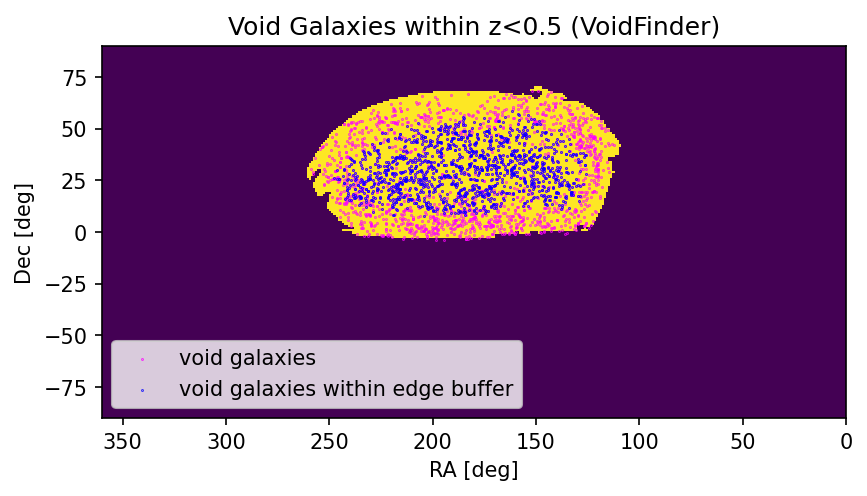

In [20]:
# Now, as a demo, let's plot some low redshift void galaxies over the survey mask
import matplotlib.pyplot as plt
import numpy as np

plt.figure(dpi=150)

#imshow sky coordinates
extent = (0, 360, -90, 90) 
#plot mask
plt.imshow(np.rot90(voidfinder_catalog.mask), # rotate mask
           extent=extent,
           interpolation='none' #turn off pixel blurring
          )

# scatter plot of RA/DEC coordiantes 
select_low_z = voidfinder_catalog.galaxies['redshift'] < .05
plt.scatter(voidfinder_catalog.galaxies[select_low_z*voidfinder_catalog.galaxies['vflag']==1]['ra'],
            voidfinder_catalog.galaxies[select_low_z*voidfinder_catalog.galaxies['vflag']==1]['dec'],
            s=.1, c='magenta', label = 'void galaxies')
plt.scatter(voidfinder_catalog.galaxies[select_low_z*select_galaxies_in_void]['ra'],
            voidfinder_catalog.galaxies[select_low_z*select_galaxies_in_void]['dec'],
            s=.1, c='blue', label = 'void galaxies within edge buffer')

plt.xlim(360,0) # Reverse x axis
plt.xlabel('RA [deg]'); plt.ylabel('Dec [deg]')
plt.legend(loc='lower left')
plt.gca().set_aspect('equal', adjustable='box')
plt.title('Void Galaxies within z<0.5 (VoidFinder)')
plt.show();


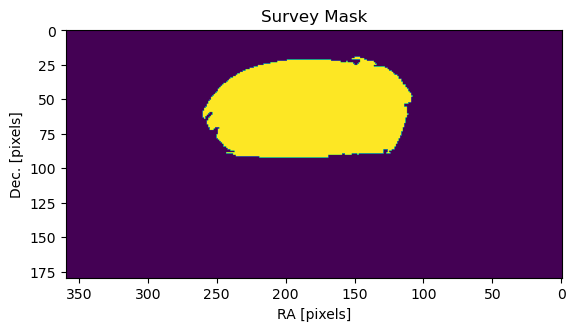

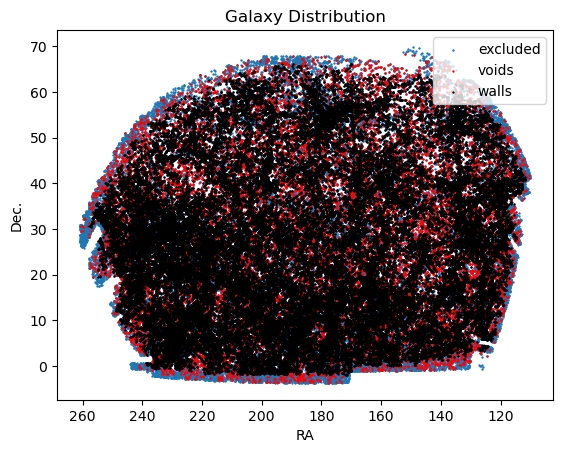

In [21]:
# There is also a built in function for plotting the angular distribution of the galaxies, 
# color-coded by their void membership
voidfinder_catalog.plot_vflag()

In [22]:
# For V2 voids, we can similary select void galaxies within the edge buffer
select_galaxies_in_void, num_galaxies = vsquared_catalog.galaxy_membership(return_selector=True)


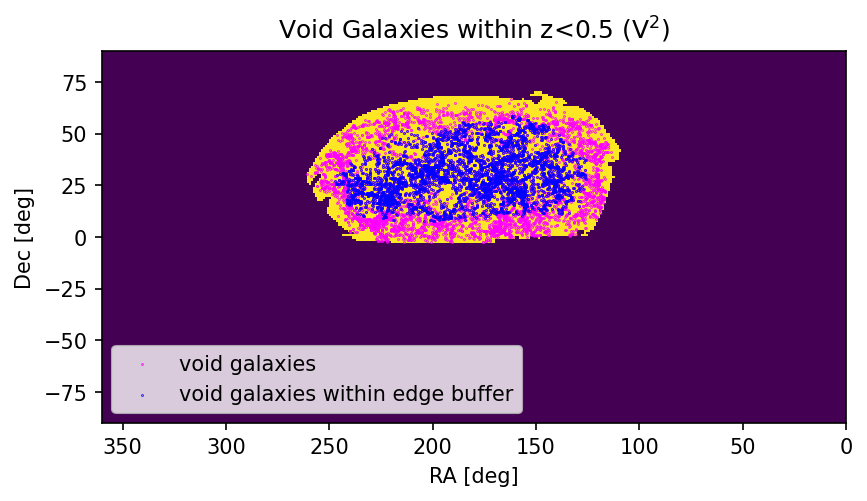

In [23]:
# Now, as a demo, let's plot some low redshift void galaxies over the survey mask
import matplotlib.pyplot as plt
import numpy as np

plt.figure(dpi=150)

#imshow sky coordinates
extent = (0, 360, -90, 90) 
#plot mask
plt.imshow(np.rot90(vsquared_catalog.mask), # rotate mask
           extent=extent,
           interpolation='none' #turn off pixel blurring
          )

# scatter plot of RA/DEC coordiantes 
select_low_z = vsquared_catalog.galaxies['redshift'] < .05
plt.scatter(vsquared_catalog.galaxies[select_low_z*vsquared_catalog.galaxies['vflag']==1]['ra'],
            vsquared_catalog.galaxies[select_low_z*vsquared_catalog.galaxies['vflag']==1]['dec'],
            s=.1, c='magenta', label = 'void galaxies')
plt.scatter(vsquared_catalog.galaxies[select_low_z*select_galaxies_in_void]['ra'],
            vsquared_catalog.galaxies[select_low_z*select_galaxies_in_void]['dec'],
            s=.1, c='blue', label = 'void galaxies within edge buffer')

plt.xlim(360,0) # Reverse x axis
plt.xlabel('RA [deg]'); plt.ylabel('Dec [deg]')
plt.legend(loc='lower left')
plt.gca().set_aspect('equal', adjustable='box')
plt.title('Void Galaxies within z<0.5 (V$^2$)')
plt.show();


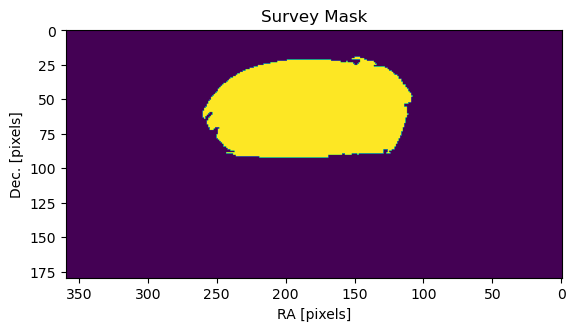

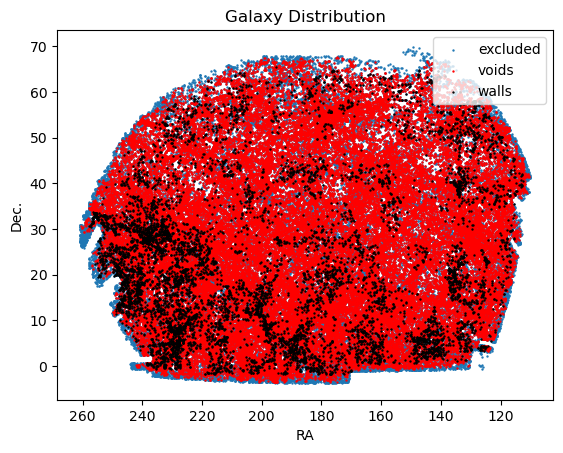

In [24]:
# We can also use the built in environment plotting function for V2
vsquared_catalog.plot_vflag()

### Is My Object in a Void?

In [20]:
# We can calculate vflags for individual coordiates provided to a function input
# As said before, the vflags can take on the following values
# 0 = wall galaxy
# 1 = void galaxy
# 2 = edge galaxy (too close to survey boundary to determine). A fixed, 10 Mpc/h nearest-edge threshold is used for this calculation, 
# seperate from the user-specified void catalog edge buffer, i.e. voidfinder_catalog = VoidFinderCatalog(voidfinder_voids_path, edge_buffer=30)
# The fixed, 10 Mpc/h threshold corresponds to the capabilites of the VoidFinder algorithm
# 9 = outside survey footprint
# Note that the any galaxy in a void will be marked as a void galaxy, even if it is close to the survey edge. 
# The edge galaxy classification is only given to non-void galaxies.

# Let's check the VoidFinder void membership of two coordinates in ra-dec-z space
vflags = voidfinder_catalog.check_object_in_void(ra=[210, 210], dec=[20, 20], redshift=[.07, .09])
print(vflags)
# Let's check the V2 void membership of a single coordinate in xyz space
# TODO: remove this requriement
"""vsquared_catalog.galzone['x'] = vsquared_catalog.galaxies['x']
vsquared_catalog.galzone['y'] = vsquared_catalog.galaxies['y']
vsquared_catalog.galzone['z'] = vsquared_catalog.galaxies['z']"""
vflags = vsquared_catalog.check_object_in_void(x_pos=-81.3, y_pos=-46.9, z_pos=34.2)
print(vflags)

[0, 1]
[1]


### Void Slice Plots

In [8]:
from vast.catalog.void_slice_plots import VoidMapVF, VoidMapV2
import matplotlib.pyplot as plt

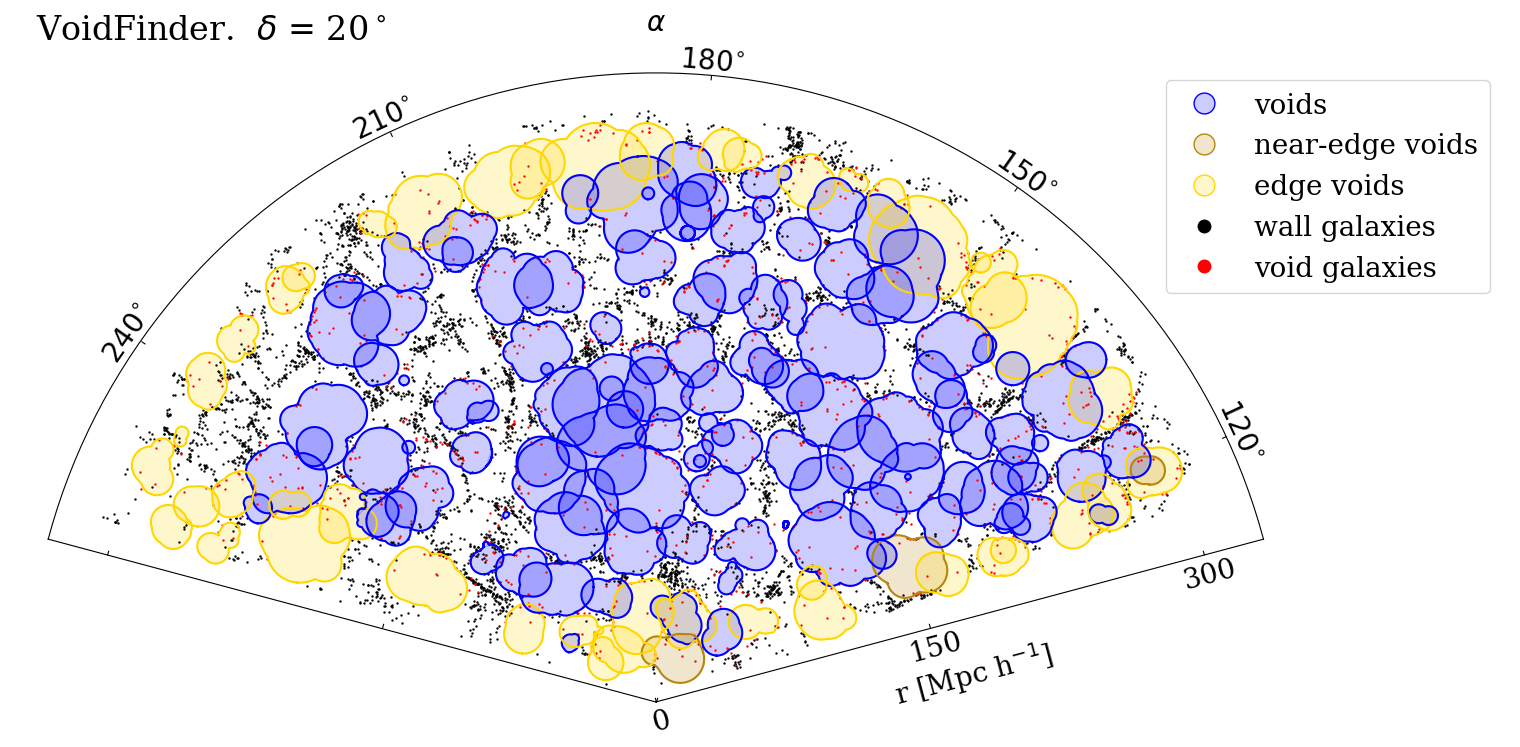

In [20]:
voidfinder_slice_plot = VoidMapVF(voidfinder_catalog.galaxies, voidfinder_catalog.maximals, voidfinder_catalog.holes)

plt.rcParams.update({'font.size': 20, 'font.family':'serif',"axes.titley":1.03 })

graph = voidfinder_slice_plot.plot_survey(20,5,1500,15, 
    110, 260, 0, 0.114, "VoidFinder. ", graph = None, zlimits = True, rot = 265, 
    colors = ['gold','darkgoldenrod','blue'],include_gals=True,alpha=0.2, border_alpha = 1,
    horiz_legend_offset=0.9,mag_limit=-20, galaxy_point_size=.5, plot_sdss=False)

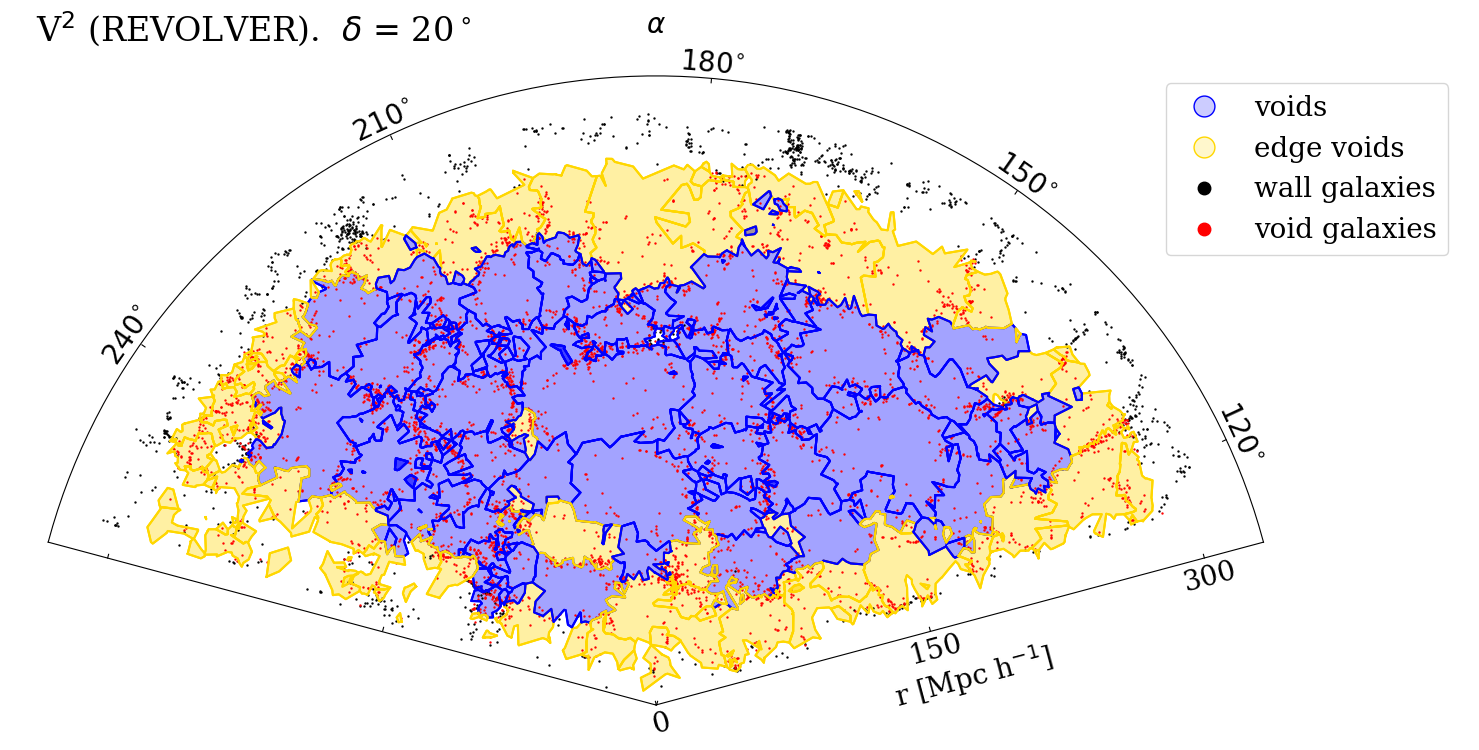

In [14]:
vsquared_slice_plot = VoidMapV2(vsquared_catalog.triangle, vsquared_catalog.galzone, vsquared_catalog.zonevoid,
                   vsquared_catalog.voids, vsquared_catalog.galaxies)

plt.rcParams.update({'font.size': 20, 'font.family':'serif',"axes.titley":1.03 })

graph = vsquared_slice_plot.plot_survey(20,5,
    110, 260, 0, 0.114,"V$^2$ (REVOLVER). ", graph = None, zlimits = True, rot = 265, 
    colors = ['gold','blue'],include_gals=True,alpha=0.2, border_alpha = 1, mag_limit=-20, 
    horiz_legend_offset=0.9, galaxy_point_size=.5, plot_sdss=False)
